In [67]:
# Import pandas and numpy libraries

import pandas as pd
import numpy as np

In [68]:
# Read train data from csv file

train_df = pd.read_csv('Ames_train.csv')
train_df.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,527402250,20,RL,NaN,12537,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,149900
1,923225240,160,RM,41.0,2665,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,127000
2,534178010,20,RL,80.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2007,COD,Normal,127000
3,905452160,20,RL,75.0,9525,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,128000
4,535376100,30,RL,60.0,5400,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2006,WD,Abnorml,108480


In [69]:
# For the example codes, I will only use 
# 4 variables and the target price
train_df = train_df[['Gr Liv Area',
                     'Garage Area',
                     'Year Built',
                     'Garage Finish',
                     'MS Zoning',
                     'SalePrice']]

train_df.head()

,Gr Liv Area,Garage Area,Year Built,Garage Finish,MS Zoning,SalePrice
0,1078,500.0,1971,Fin,RL,149900
1,1475,336.0,1977,RFn,RM,127000
2,1052,311.0,1963,Fin,RL,127000
3,1172,366.0,1954,Fin,RL,128000
4,1073,326.0,1921,Unf,RL,108480


In [70]:
from sklearn.preprocessing import OneHotEncoder

# We define our One Hot Encoder
ohe = OneHotEncoder(categories='auto', handle_unknown='ignore')

# We can use here a list of one or more categorical variables to convert into numerical
#categorical_features = ['Garage Finish', 'MS Zoning']
categorical_features = [col for col in train_df.columns if train_df[col].dtype == 'object']
print(categorical_features)

# We apply the encoding to our train dataset
feature_arr = ohe.fit_transform(train_df[categorical_features]).toarray()

# We also store the names of the categories for the new column names
feature_labels = ohe.categories_

# We apply the new feature names
features = pd.DataFrame(feature_arr, columns=ohe.get_feature_names_out())

# And then combine with the rest of the numerical variables
train_df = pd.concat([train_df, features], axis=1).drop(columns=categorical_features, 
                                                        axis=1)

train_df.head()

['Garage Finish', 'MS Zoning']


,Gr Liv Area,Garage Area,Year Built,SalePrice,Garage Finish_Fin,Garage Finish_RFn,Garage Finish_Unf,Garage Finish_nan,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM
0,1078,500.0,1971,149900,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1475,336.0,1977,127000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1052,311.0,1963,127000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1172,366.0,1954,128000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1073,326.0,1921,108480,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [41]:
# Now, I'll keep just my 4 variables (they are 7 now after OHE)
# We will use the standard naming of:
# - X for the dataframe including all the input variables
# - y for the target 1-column dataframe

X = train_df.drop(columns=['SalePrice']).fillna(0)             
    
y = train_df[['SalePrice']]

# We print the shape to get a better idea of the number 
# of rows and columns that we got

X.shape, y.shape

((2344, 14), (2344, 1))

In [42]:
from sklearn.model_selection import train_test_split

# As seen before, we need to create a random split for validation
# in this case, we'll use a 30% split.

X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.3, 
                                                  random_state=2023)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1640, 14), (704, 14), (1640, 1), (704, 1))

In [43]:
# We'll iterate through different number of min_samples_leaf and max_depth, 
# then train the model, and test it using logarithmic MSE
# in both train and validations sets:

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

result_train_dict = {}
result_val_dict = {}

max_min_samples_leaf = 50
max_max_depth = 15

for m in range(3, max_max_depth+1, 2):
    for n in range(1, max_min_samples_leaf+1, 3):
        
        tree_reg = DecisionTreeRegressor(random_state=42, 
                                         min_samples_leaf=n, 
                                         max_depth=m)
        tree_reg.fit(X_train, y_train)

        train_predicted = tree_reg.predict(X_train)
        val_predicted = tree_reg.predict(X_val)

        result_train_dict[m, n] = mean_squared_error(np.log(y_train), 
                                                     np.log(train_predicted), 
                                                     squared = False)
        result_val_dict[m, n] = mean_squared_error(np.log(y_val), 
                                                   np.log(val_predicted), 
                                                   squared = False)

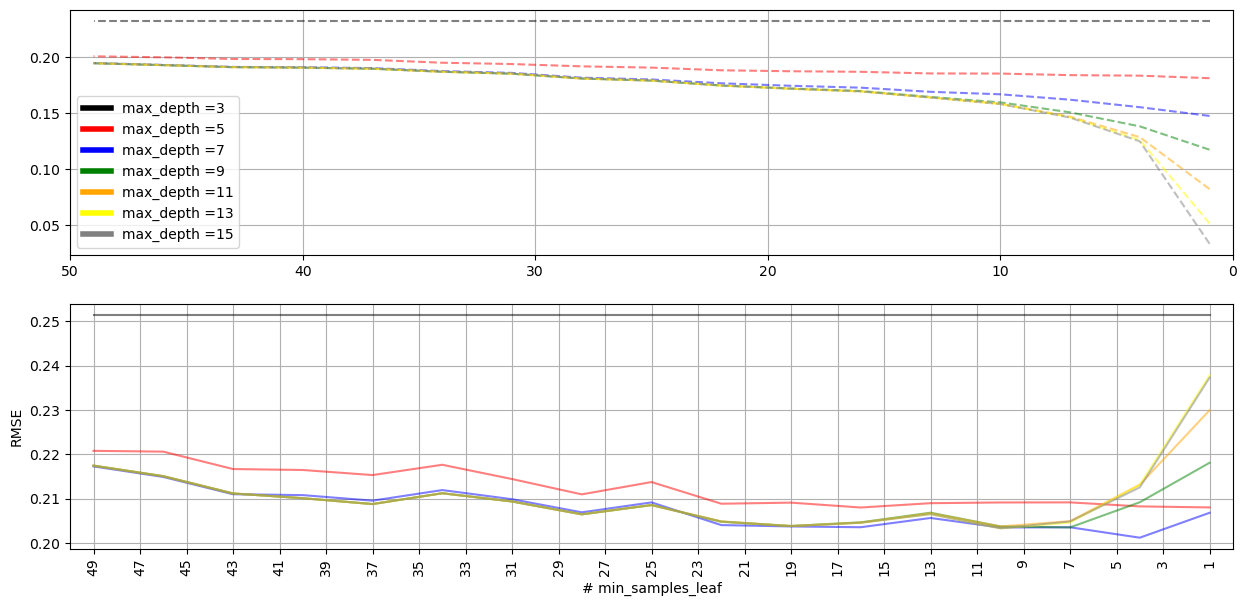

In [44]:
# We are going to plot the different train and validation errors, 
# so we can then choose the best value for both max_depth and min_samples_leaf

# Remember: "Best" means lower MSE in the validation subset, not in training:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7))
colors= ['black', 'red', 'blue', 'green', 'orange', 'yellow', 'gray']
color_index = 0
custom_lines = np.array([])
custom_names = np.array([])

x_axis = np.arange(start=1, stop=max_min_samples_leaf+1, step=3)

for m in range(3, max_max_depth+1, 2):
    
    line_plot_train = []
    line_plot_val = []
    
    for n in x_axis:
        line_plot_train.append(result_train_dict.get((m,n)))
        line_plot_val.append(result_val_dict.get((m,n)))

    ax1.plot(x_axis, line_plot_train, alpha=0.5, c=colors[color_index], linestyle='--')
    ax2.plot(x_axis, line_plot_val, alpha=0.5, c=colors[color_index])
    
    color_line = Line2D([0], [0], color=colors[color_index], lw=4)
    custom_lines = np.append(custom_lines,color_line)
    color_name = 'max_depth =' + str(m)
    custom_names = np.append(custom_names,color_name)
    color_index+=1

ax1.set_xlim(max_min_samples_leaf, 0)
ax2.set_xlim(max_min_samples_leaf, 0)

plt.xticks(np.arange(start=1, stop=max_min_samples_leaf, step=2), rotation=90, size=10)

ax1.grid(True)
ax2.grid(True)

plt.xlabel('# min_samples_leaf')
plt.ylabel('RMSE')

ax1.legend(custom_lines, custom_names)

plt.show()

In [45]:
# Once the parameters has been picked, we can fit and predict both train and validation
# and double check that the error values we are getting are the ones in the graph

tree_reg = DecisionTreeRegressor(random_state=42, min_samples_leaf=7, max_depth=7)
tree_reg.fit(X_train, y_train)

train_predicted = tree_reg.predict(X_train)
val_predicted = tree_reg.predict(X_val)

(mean_squared_error(np.log(y_train), np.log(train_predicted), squared = False),
 mean_squared_error(np.log(y_val), np.log(val_predicted), squared = False))

(0.16193232850210773, 0.2035550363344975)

In [46]:
# Apply the model parameters to the whole train dataset
# getting a similar MSE that we got for training

tree_reg = DecisionTreeRegressor(random_state=42, min_samples_leaf=7, max_depth=7)
tree_reg.fit(X, y)

train_predicted = tree_reg.predict(X)

mean_squared_error(np.log(y), np.log(train_predicted), squared = False)

0.16710329875220584

In [62]:
# Read the test csv file, and repeat the process:

test_df = pd.read_csv('Ames_test.csv')
test_df.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
1,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
2,527358200,85,RL,85.0,10625,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,1,2010,WD,Family,170000
3,527368020,60,FV,NaN,7500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,216000
4,527425090,20,RL,70.0,10500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,ConLI,Normal,115000


In [63]:
# Keep the same variables, apply the same transformations

test_df = test_df[['Gr Liv Area',
                   'Garage Area',
                   'Year Built',
                   'Garage Finish',
                   'MS Zoning',
                   'SalePrice']]

In [65]:
# Careful! For the test set, we just APPLY the One Hote Encoder
# So we only use "transform", not "fit" and "transform".

categorical_features = ['Garage Finish', 'MS Zoning']
print(categorical_features)

feature_arr = ohe.transform(test_df[categorical_features]).toarray()
feature_labels = ohe.categories_

features = pd.DataFrame(feature_arr, columns=ohe.get_feature_names_out())
test_df = pd.concat([test_df, features], axis=1).drop(columns=categorical_features, 
                                                      axis=1)

test_df.head()

['Garage Finish', 'MS Zoning']


,Gr Liv Area,Garage Area,Year Built,SalePrice,Garage Finish_Fin,Garage Finish_RFn,Garage Finish_Unf,Garage Finish_nan,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM
0,896,730.0,1961,105000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2110,522.0,1968,244000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1173,528.0,1974,170000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1674,663.0,2000,216000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,864,0.0,1971,115000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
# We keep the same set of variables

X_test= test_df.drop(columns=['SalePrice']).fillna(0)
y_test = test_df[['SalePrice']].copy()

In [34]:
# Apply the already previously trained tree to our test dataset:

y_test['SalePrice_predicted'] = tree_reg.predict(X_test)
y_test.head()

,SalePrice,SalePrice_predicted
0,105000,140314.957143
1,244000,213092.187500
2,170000,149882.456140
3,216000,226213.650000
4,115000,124080.546667


In [35]:
# What error are we getting for the test set?

print(mean_squared_error(np.log(y_test['SalePrice']), 
                         np.log(y_test['SalePrice_predicted']), 
                         squared = False))

0.2336426503173686
